# Analyze ParaRel causal tracing results

In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from experiments.causal_trace import plot_trace_heatmap

In [2]:
query_file = "/cephyr/users/lovhag/Alvis/projects/rome/data/P19_gpt2_xl_preds.jsonl"
results_folder = "/cephyr/users/lovhag/Alvis/projects/rome/results/ns3_r0_gpt2-xl/causal_trace_pararel/cases"

## Load the queries

In [3]:
queries = pd.DataFrame()
with open(query_file) as f:
    for line in f:
        queries = queries.append(json.loads(line), ignore_index=True)
        
queries.head()

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template
0,Alexandra,0.001767,Chicago,39.0,1.400000e-07,20169.0,0.0,the,0.370901,Allan Peiper was born in,P19,Allan Peiper,{} was born in
1,Alexandra,0.040801,Chicago,1.0,6.400000e-07,15598.0,1.0,the,0.273378,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from
2,Alexandra,0.009765,Chicago,7.0,3.000000e-07,17909.0,2.0,the,0.323059,Allan Peiper was originally from,P19,Allan Peiper,{} was originally from
3,Alexandra,0.000129,Chicago,458.0,2.000000e-08,36370.0,3.0,the,0.496370,Allan Peiper is native to,P19,Allan Peiper,{} is native to
4,Alexandra,0.000130,Spain,482.0,7.000000e-08,29934.0,4.0,the,0.449806,Allan Peiper was native to,P19,Allan Peiper,{} was native to


### Analyze query data

What to analyze specifically?

Do we have any correlations between candidate and gold rankings? (could we look at just one of them?)

In [4]:
queries.drop(columns="known_id").corr(method="pearson")

,candidate_p,candidate_rank,gold_p,gold_rank,prediction_p
candidate_p,1.000000,-0.241190,0.624207,-0.318054,-0.298055
candidate_rank,-0.241190,1.000000,-0.152285,0.366231,0.341414
gold_p,0.624207,-0.152285,1.000000,-0.231004,-0.201423
gold_rank,-0.318054,0.366231,-0.231004,1.000000,0.233511
prediction_p,-0.298055,0.341414,-0.201423,0.233511,1.000000


In [5]:
queries.drop(columns="known_id").corr(method="spearman")

,candidate_p,candidate_rank,gold_p,gold_rank,prediction_p
candidate_p,1.000000,-0.968091,0.726986,-0.659085,-0.609945
candidate_rank,-0.968091,1.000000,-0.713089,0.681383,0.480004
gold_p,0.726986,-0.713089,1.000000,-0.976376,-0.484050
gold_rank,-0.659085,0.681383,-0.976376,1.000000,0.367988
prediction_p,-0.609945,0.480004,-0.484050,0.367988,1.000000


What values do the candidate rankings and gold rankings take?

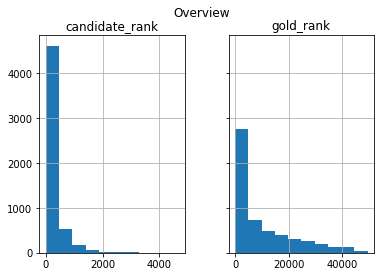

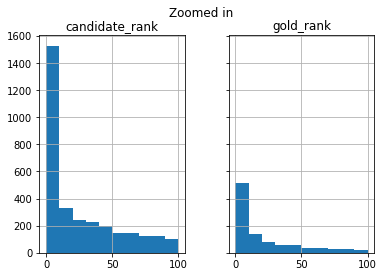

Total number of samples: 5453


In [9]:
hist2 = queries.hist(column=["candidate_rank", "gold_rank"], sharey=True)
plt.suptitle("Overview")
plt.show()

hist = queries.hist(column=["candidate_rank", "gold_rank"], sharey=True, range=[0,100])
plt.suptitle("Zoomed in")
plt.show()
print(f"Total number of samples: {len(queries)}")

### Group model predictions into different categories
Can for example group by:
- TE (model prediction probably not that factual)
- Candidate rank
- Gold rank
- Probability values assigned

Are there correlations between these?

In [6]:
queries["candidate_rank_bin"] = pd.qcut(queries.candidate_rank, 4) # each bin contains equal number of samples
queries["gold_rank_bin"] = pd.qcut(queries.gold_rank, 4)
queries.head()

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,candidate_rank_bin,gold_rank_bin
0,Alexandra,0.001767,Chicago,39.0,1.400000e-07,20169.0,0.0,the,0.370901,Allan Peiper was born in,P19,Allan Peiper,{} was born in,"(6.0, 64.0]","(16314.0, 49585.0]"
1,Alexandra,0.040801,Chicago,1.0,6.400000e-07,15598.0,1.0,the,0.273378,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from,"(-0.001, 6.0]","(4780.0, 16314.0]"
2,Alexandra,0.009765,Chicago,7.0,3.000000e-07,17909.0,2.0,the,0.323059,Allan Peiper was originally from,P19,Allan Peiper,{} was originally from,"(6.0, 64.0]","(16314.0, 49585.0]"
3,Alexandra,0.000129,Chicago,458.0,2.000000e-08,36370.0,3.0,the,0.496370,Allan Peiper is native to,P19,Allan Peiper,{} is native to,"(260.0, 4677.0]","(16314.0, 49585.0]"
4,Alexandra,0.000130,Spain,482.0,7.000000e-08,29934.0,4.0,the,0.449806,Allan Peiper was native to,P19,Allan Peiper,{} was native to,"(260.0, 4677.0]","(16314.0, 49585.0]"


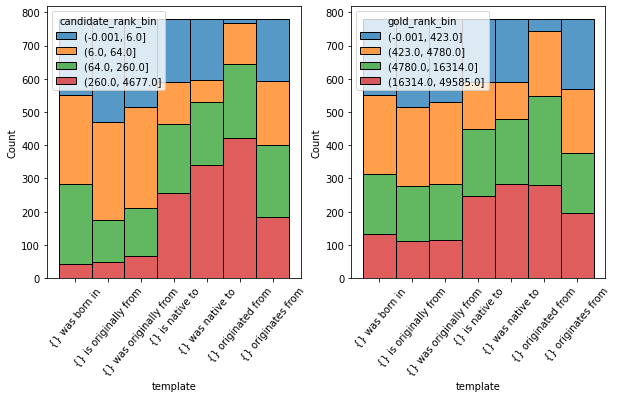

In [7]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1,2,1)
sns.histplot(data=queries, x="template", hue="candidate_rank_bin", multiple="stack")
plt.xticks(rotation=50)

ax = plt.subplot(1,2,2)
sns.histplot(data=queries, x="template", hue="gold_rank_bin", multiple="stack")
plt.xticks(rotation=50)
plt.show()

Potentially, the templates "{} is native to", "{} was native to" and "{} originated from" are more problematic for GPT2-XL.

In [8]:
cat_val = queries.candidate_rank_bin.cat.categories[0]
queries[queries.candidate_rank_bin==cat_val]

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,candidate_rank_bin,gold_rank_bin
1,Alexandra,0.040801,Chicago,1.0,6.400000e-07,15598.0,1.0,the,0.273378,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from,"(-0.001, 6.0]","(4780.0, 16314.0]"
9,Scotland,0.018402,India,4.0,3.753400e-04,210.0,9.0,the,0.188557,Paul Mounsey was originally from,P19,Paul Mounsey,{} was originally from,"(-0.001, 6.0]","(-0.001, 423.0]"
21,Vienna,0.024330,Germany,2.0,5.587770e-03,11.0,21.0,the,0.054772,Kurt Schwertsik was born in,P19,Kurt Schwertsik,{} was born in,"(-0.001, 6.0]","(-0.001, 423.0]"
22,Vienna,0.039167,Germany,1.0,2.687580e-03,63.0,22.0,the,0.087899,Kurt Schwertsik is originally from,P19,Kurt Schwertsik,{} is originally from,"(-0.001, 6.0]","(-0.001, 423.0]"
23,Vienna,0.033115,Germany,1.0,2.828450e-03,60.0,23.0,the,0.094075,Kurt Schwertsik was originally from,P19,Kurt Schwertsik,{} was originally from,"(-0.001, 6.0]","(-0.001, 423.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5440,Dublin,0.020274,Chicago,5.0,3.139000e-05,1465.0,5440.0,the,0.132704,Lorraine Pilkington is originally from,P19,Lorraine Pilkington,{} is originally from,"(-0.001, 6.0]","(423.0, 4780.0]"
5446,Lisbon,0.045418,Lisbon,2.0,4.541760e-02,2.0,5446.0,the,0.085641,Lopo Soares de Albergaria was born in,P19,Lopo Soares de Albergaria,{} was born in,"(-0.001, 6.0]","(-0.001, 423.0]"
5447,Lisbon,0.032361,Lisbon,5.0,3.236125e-02,5.0,5447.0,Brazil,0.199201,Lopo Soares de Albergaria is originally from,P19,Lopo Soares de Albergaria,{} is originally from,"(-0.001, 6.0]","(-0.001, 423.0]"
5448,Lisbon,0.029673,Lisbon,5.0,2.967252e-02,5.0,5448.0,Brazil,0.185048,Lopo Soares de Albergaria was originally from,P19,Lopo Soares de Albergaria,{} was originally from,"(-0.001, 6.0]","(-0.001, 423.0]"


## Load the causal tracing results

In [6]:
results = np.load("/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/causal_trace_pararel_1557225/cases/0_any.npz", allow_pickle=True)

In [11]:
res = dict(results)
res

{'scores': array([[0.14224863, 0.14200114, 0.13937525, 0.12456983, 0.12145109,
         0.11614361, 0.11690114, 0.12581626, 0.12810296, 0.12850493,
         0.128569  , 0.12921654, 0.12976107, 0.1289017 , 0.1291825 ,
         0.12934469, 0.12934397, 0.1291701 , 0.12913848, 0.12884484,
         0.12872083, 0.12905526, 0.12915997, 0.12946701, 0.12953798,
         0.12930611, 0.12958074, 0.12947713, 0.12937042, 0.12947133,
         0.12952158, 0.12939592, 0.12918334, 0.1292812 , 0.12926601,
         0.12904294, 0.12907474, 0.1289218 , 0.12878925, 0.12870155,
         0.12870581, 0.12862544, 0.12864974, 0.12870157, 0.12877554,
         0.12884954, 0.12883763, 0.12891498],
        [0.13378465, 0.1391238 , 0.12703173, 0.11411332, 0.09580653,
         0.07784909, 0.07316283, 0.07074521, 0.07050457, 0.07301632,
         0.07574222, 0.07865351, 0.08383738, 0.09865558, 0.1096954 ,
         0.11525483, 0.11631043, 0.11482785, 0.11509333, 0.11511228,
         0.11527444, 0.1157568 , 0.11736838, 0.

In [10]:
res["scores"].shape

(7, 48)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


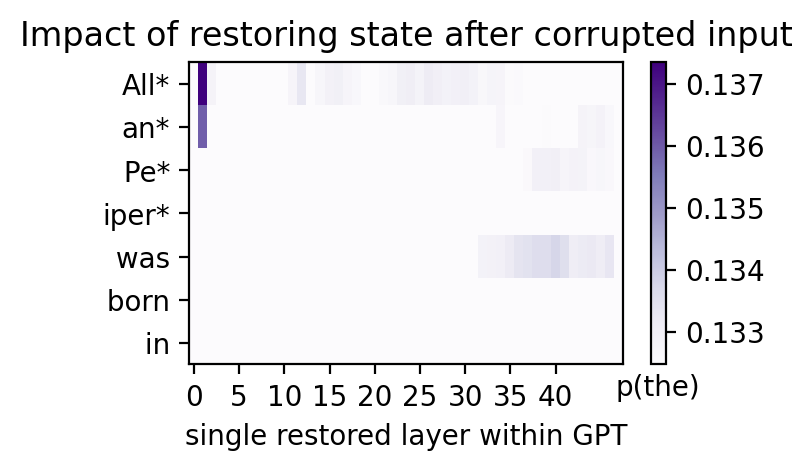

In [27]:
plot_trace_heatmap(results)

## Analyze causal tracing results

- When the model is consistent, can we observe that it treats the queries similarly? (Compared to the case when the model is not consistent)
    - Consider heatmaps
    - Consider direct effect of corrupting the subject